In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

In [2]:
def to_unix_time(dt):
    epoch = datetime.utcfromtimestamp(0)
    return (dt - epoch).total_seconds() * 1000

In [18]:
df = pd.read_csv("../data/hr_device.csv")

print "total number of lines =", len(df)

excluded_macs = ["00-17-0d-00-00-58-f8-63",
                 "00-17-0d-00-00-58-f8-78",
                 "00-17-0d-00-00-58-eb-69",]

df_clean = df[(df.charge > 0)
            #~df.mac.isin(excluded_macs)
            ]

lines_removed = len(df) - len(df_clean)
print "number of lines removed = ", lines_removed, "(", lines_removed*100/len(df), "%)"

df_clean.loc[:, "date"] = pd.to_datetime(df_clean.time, unit='s')
df_clean.set_index(df_clean["date"], inplace=True)
df_clean.head()

total number of lines = 117382
number of lines removed =  0 ( 0 %)


,time,mac,charge,queueOcc,numTxOk,numTxBad,lat,long,date
date,,,,,,,,,
2016-11-13 10:43:41,1479033821,00-17-0d-00-00-38-00-63,39213,33,32,0,48.84202,2.3845,2016-11-13 10:43:41
2016-11-13 10:58:42,1479034722,00-17-0d-00-00-38-00-63,39248,33,32,0,48.84202,2.3845,2016-11-13 10:58:42
2016-11-13 11:13:41,1479035621,00-17-0d-00-00-38-00-63,39284,33,32,0,48.84202,2.3845,2016-11-13 11:13:41
2016-11-13 11:28:42,1479036522,00-17-0d-00-00-38-00-63,39320,33,32,0,48.84202,2.3845,2016-11-13 11:28:42
2016-11-13 11:43:44,1479037424,00-17-0d-00-00-38-00-63,39356,33,32,0,48.84202,2.3845,2016-11-13 11:43:44


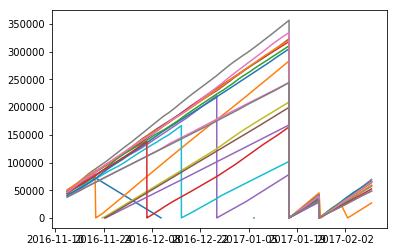

In [19]:
for name, group in df_clean.groupby(["mac"]):
    plt.plot(group.index, group.charge, label=name)
#plt.legend()

# Cleaning Charge


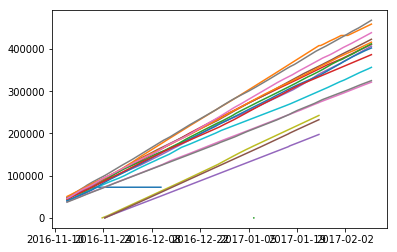

In [20]:
grouped = df_clean.groupby(["mac"])
charge_clean = []

for name, group in grouped:
    prev_charge = 0
    new_charge = 0
    charge_max = 0
    for curr_charge in group.charge:
        if curr_charge < prev_charge:
            new_charge += curr_charge
        else:
            new_charge += (curr_charge - prev_charge)
        charge_clean.append(new_charge)
        prev_charge = curr_charge

df_clean.loc[:, "charge_clean"] = pd.Series(charge_clean, index=df_clean.date)

for name, group in df_clean.groupby(["mac"]):
    plt.plot(group.index, group.charge_clean, label=name)

#plt.legend()
plt.show()

In [21]:
grouped = df_clean.groupby(["mac"])
stats = []
charge_tot = 2200 * 3600 # charge total in mC assuming 2200mAh battery

for name, group in grouped:    
    time_diff = group.time[len(group.time)-1] - group.time[0]
    if time_diff > 3600*24*30*2:
        charge_max = float(group.charge_clean.max())
        charge_left = charge_tot - charge_max
        time_left = charge_tot * time_diff / charge_max
        stats.append([name[-8:],
                      "{:,} KC".format(int(round(charge_max/1000))) +
                      " ({0}%) ".format(round(100*charge_max/charge_tot, 1)),
                      "{0} years".format(int(round(time_left/3600/24/365)))])
    
print pd.DataFrame(stats, columns=["MAC", "charge consumed", "lifetime"])\
    .set_index("MAC")\
    .to_latex(column_format="|c|c|c|")

\begin{tabular}{|c|c|c|}
\toprule
{} & charge consumed & lifetime \\
MAC      &                 &          \\
\midrule
38-03-dd &  459 KC (5.8\%)  &  4 years \\
58-e9-ca &  411 KC (5.2\%)  &  5 years \\
58-e9-cb &  407 KC (5.1\%)  &  5 years \\
58-eb-5b &  423 KC (5.3\%)  &  5 years \\
58-eb-64 &  322 KC (4.1\%)  &  6 years \\
58-eb-67 &  468 KC (5.9\%)  &  4 years \\
58-eb-69 &  243 KC (3.1\%)  &  6 years \\
58-f3-17 &  357 KC (4.5\%)  &  5 years \\
58-f4-f8 &  402 KC (5.1\%)  &  5 years \\
58-f5-23 &  416 KC (5.3\%)  &  5 years \\
58-f5-3c &  412 KC (5.2\%)  &  5 years \\
58-f5-58 &  387 KC (4.9\%)  &  5 years \\
58-f8-63 &  198 KC (2.5\%)  &  7 years \\
58-f8-78 &  233 KC (2.9\%)  &  6 years \\
58-f8-8f &  439 KC (5.5\%)  &  4 years \\
58-f9-c4 &  325 KC (4.1\%)  &  6 years \\
\bottomrule
\end{tabular}

